# 04 – Exploratory Data Analysis: Financials

In this section, we analyze the financial aspects of the Brazilian e-commerce dataset.
Our focus will be on:

- Revenue trends
- Payments breakdown
- Category-level performance
- Seller contributions
- Freight impact
- Customer spending

This helps uncover key business insights into profitability, top categories, and customer behavior.


In [25]:
# Standard libraries
import os
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10


We load the **cleaned** and **engineered** datasets created in previous steps.
- Processed data → cleaned base files
- Interim data → engineered features such as revenue, spending, etc.


In [26]:
# Paths
processed_path = "../data/processed/"
interim_path = "../data/interim/"

# Load processed data
orders = pd.read_csv(os.path.join(processed_path, "orders_cleaned.csv"))
payments = pd.read_csv(os.path.join(processed_path, "payments_cleaned.csv"))
products = pd.read_csv(os.path.join(processed_path, "products_cleaned.csv"))
categories = pd.read_csv(os.path.join(processed_path, "categories_cleaned.csv"))

# Load engineered features (from 03_feature_engineering)
customer_features = pd.read_csv(os.path.join(interim_path, "customer_features.csv"))
seller_features = pd.read_csv(os.path.join(interim_path, "seller_features.csv"))
order_features = pd.read_csv(os.path.join(interim_path, "order_features.csv"))
payment_features = pd.read_csv(os.path.join(interim_path, "payment_features.csv"))


First, we preview the shape of the main datasets to understand what we are working with.


In [27]:
print("Orders:", orders.shape)
print("Payments:", payments.shape)
print("Products:", products.shape)
print("Categories:", categories.shape)
print("Customers (features):", customer_features.shape)
print("Sellers (features):", seller_features.shape)


Orders: (99441, 8)
Payments: (103886, 5)
Products: (32951, 9)
Categories: (71, 2)
Customers (features): (99441, 9)
Sellers (features): (3095, 7)


We analyze **monthly revenue** by aggregating `payment_value` by order purchase date.
This highlights seasonality and growth trends.


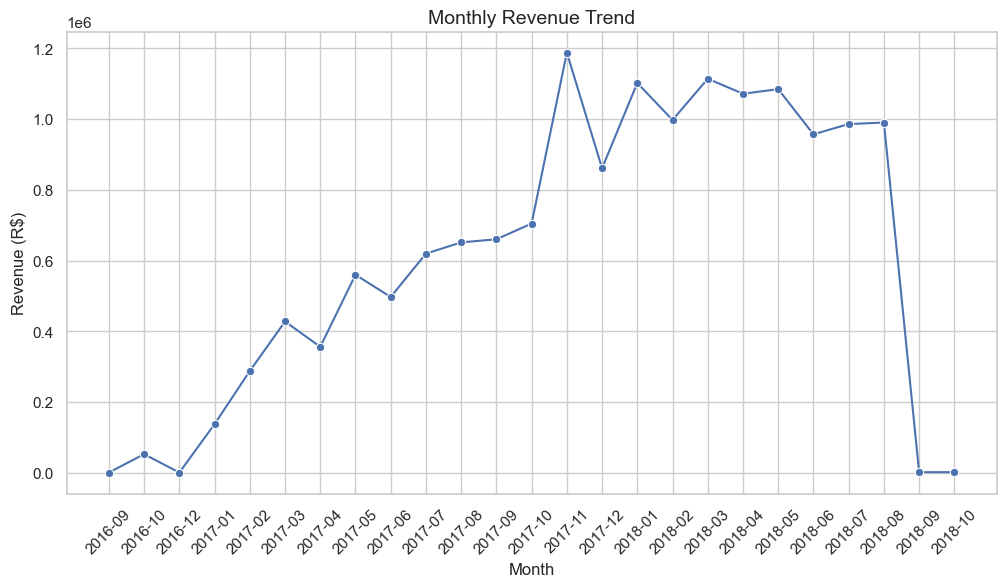

In [28]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
monthly_revenue = (
    orders.merge(payments, on="order_id")
    .groupby(orders["order_purchase_timestamp"].dt.to_period("M"))["payment_value"]
    .sum()
    .reset_index()
)
monthly_revenue["order_purchase_timestamp"] = monthly_revenue["order_purchase_timestamp"].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x="order_purchase_timestamp", y="payment_value", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue (R$)")
plt.xlabel("Month")
plt.show()


We examine how customers pay by looking at the share of each `payment_type`.


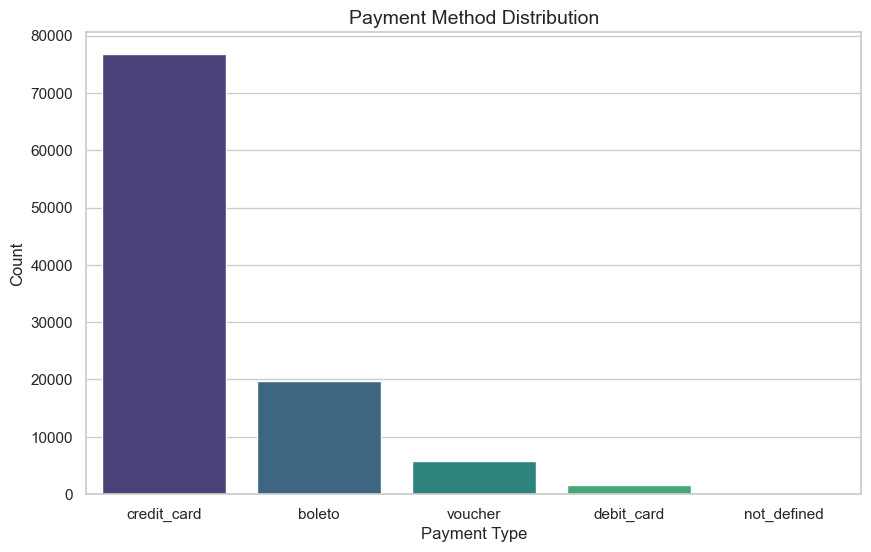

In [30]:
sns.countplot(
    x="payment_type",
    hue="payment_type",
    data=payments,
    order=payments["payment_type"].value_counts().index,
    palette="viridis",
    legend=False
)
plt.title("Payment Method Distribution")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.show()


Many customers use **installment payments**.
We analyze how common installments are and their impact on order value.


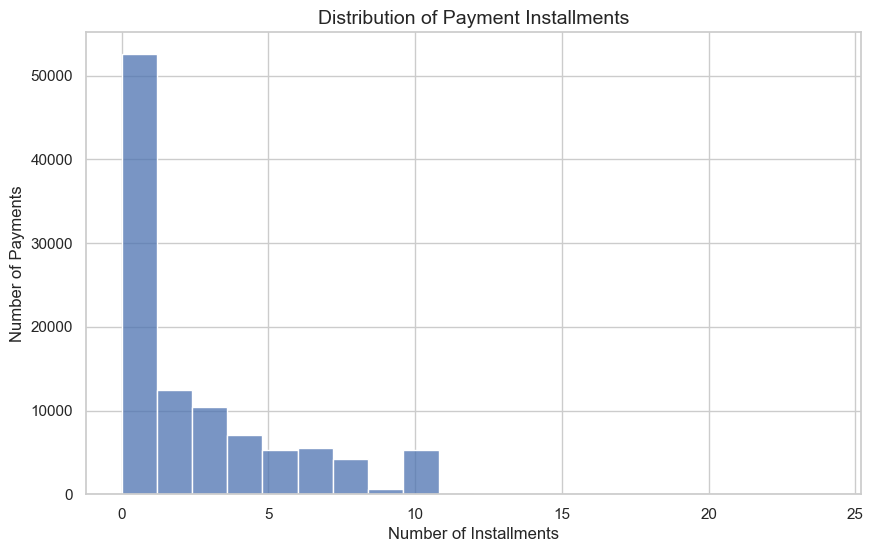

In [31]:
sns.histplot(payments["payment_installments"], bins=20, kde=False)
plt.title("Distribution of Payment Installments")
plt.xlabel("Number of Installments")
plt.ylabel("Number of Payments")
plt.show()


Freight is a significant part of e-commerce costs.  
We explore its relationship with total payment value.


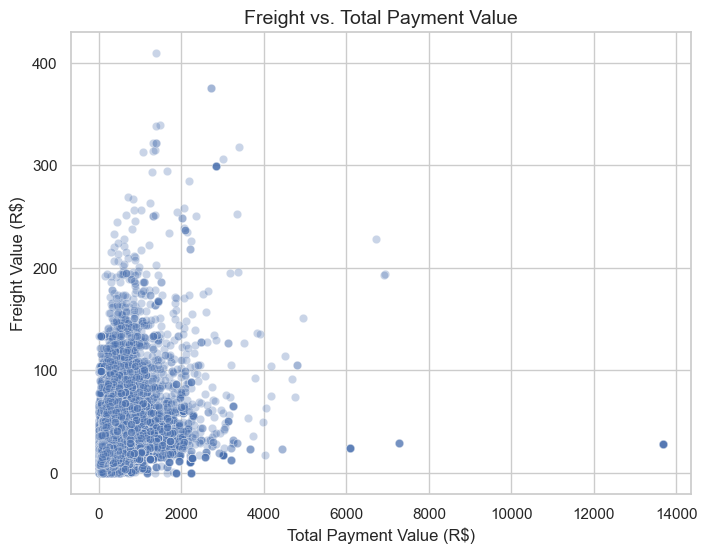

In [33]:
# Merge orders with order_items to get freight_value
order_items_merge = orders.merge(order_items[["order_id", "freight_value"]], on="order_id", how="left")

# Merge with payments to bring payment_value
order_payments = order_items_merge.merge(payments[["order_id", "payment_value"]], on="order_id", how="left")

# Scatter plot freight vs payment
plt.figure(figsize=(8,6))
sns.scatterplot(x="payment_value", y="freight_value", data=order_payments, alpha=0.3)
plt.title("Freight vs. Total Payment Value")
plt.xlabel("Total Payment Value (R$)")
plt.ylabel("Freight Value (R$)")
plt.show()


We analyze which **product categories** generate the highest revenue.


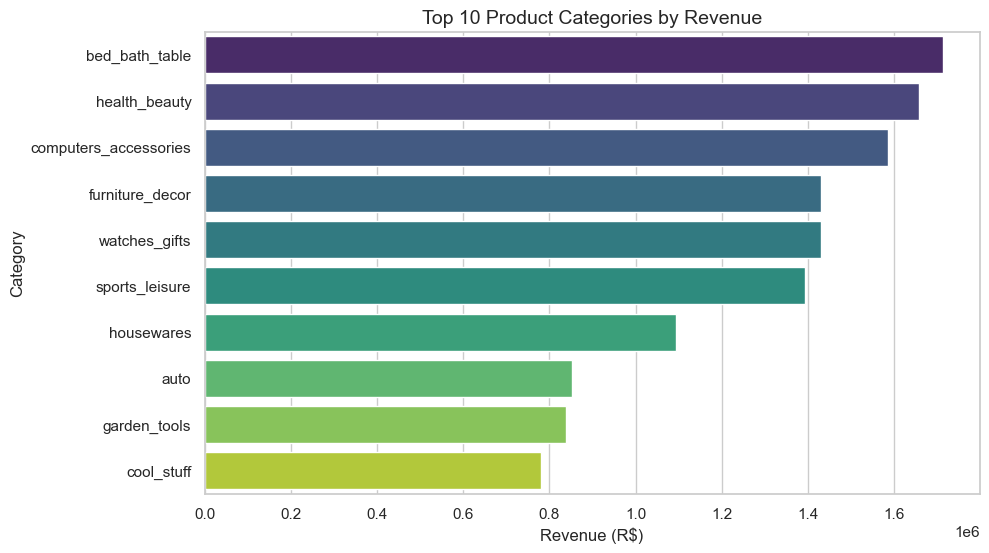

In [37]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=cat_revenue.reset_index().head(10),
    x="payment_value", 
    y="category_final", 
    hue="category_final",   # assign hue
    palette="viridis", 
    legend=False            # remove legend duplication
)
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Revenue (R$)")
plt.ylabel("Category")
plt.show()


We identify the **highest earning sellers** in the marketplace.


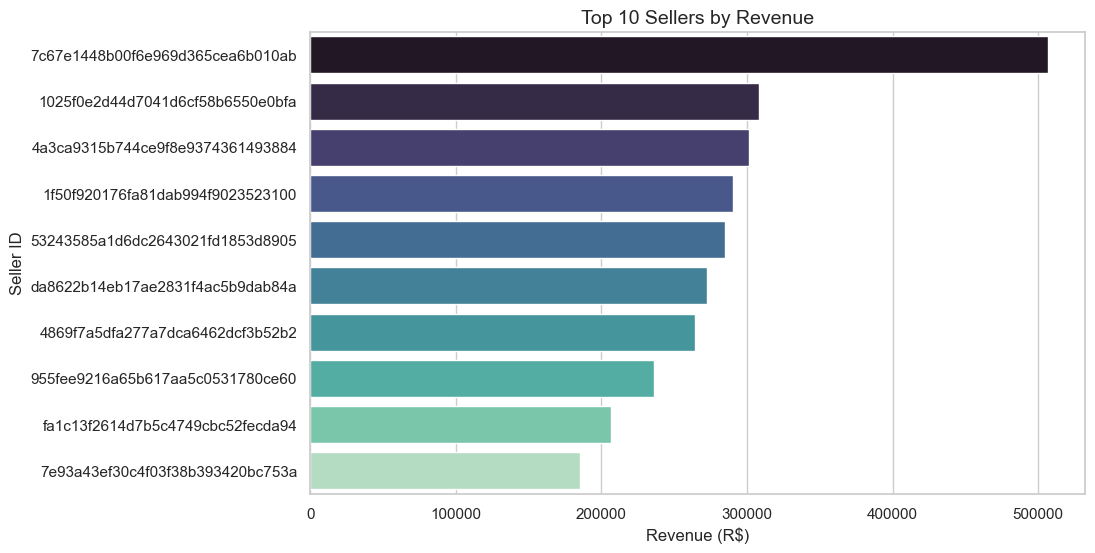

In [40]:
# Top 10 sellers by revenue
top_sellers = seller_features.sort_values("seller_revenue", ascending=False).head(10)

sns.barplot(
    data=top_sellers,
    x="seller_revenue",
    y="seller_id",
    hue="seller_id",   # avoids FutureWarning in Seaborn
    palette="mako",
    legend=False
)
plt.title("Top 10 Sellers by Revenue")
plt.xlabel("Revenue (R$)")
plt.ylabel("Seller ID")
plt.show()


We explore the distribution of **customer spending** to see how much customers typically spend.


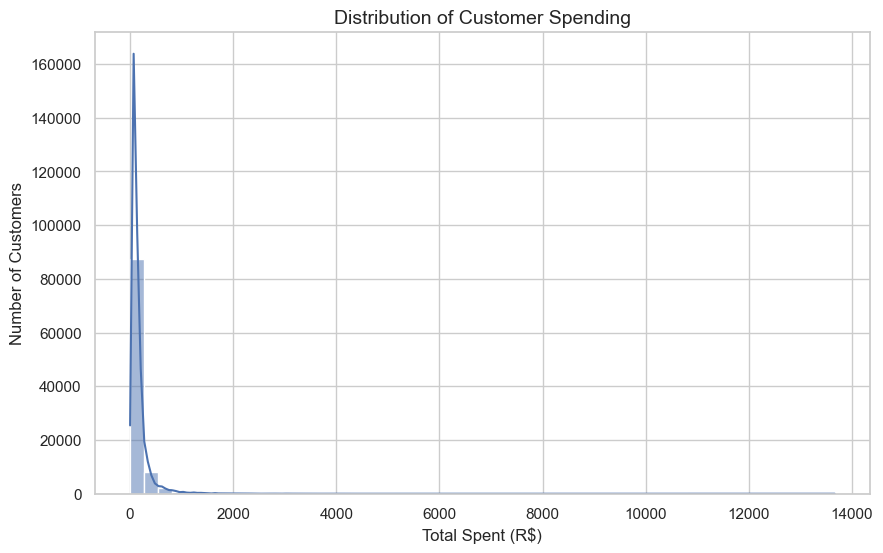

In [41]:
sns.histplot(customer_features["total_spent"], bins=50, kde=True)
plt.title("Distribution of Customer Spending")
plt.xlabel("Total Spent (R$)")
plt.ylabel("Number of Customers")
plt.show()


We compare **average payment value** across different numbers of installments.


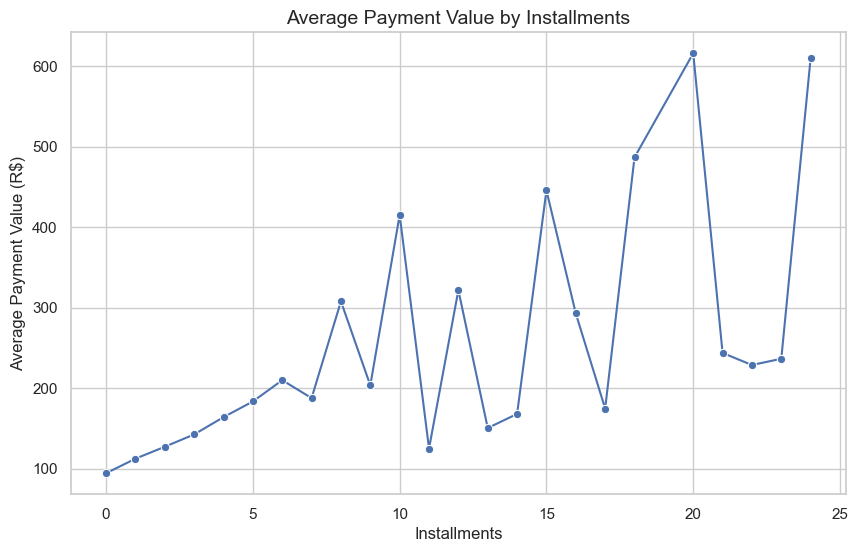

In [42]:
avg_installments = payments.groupby("payment_installments")["payment_value"].mean().reset_index()

sns.lineplot(data=avg_installments, x="payment_installments", y="payment_value", marker="o")
plt.title("Average Payment Value by Installments")
plt.xlabel("Installments")
plt.ylabel("Average Payment Value (R$)")
plt.show()


# Summary of Financial EDA

Key insights from the financial analysis:

- **Revenue growth** shows clear trends over time with seasonal peaks.
- **Payment methods**: Credit card dominates, but other methods (boleto, voucher) play a role.
- **Installments** are very common in Brazil, making e-commerce more accessible.
- **Freight costs** represent a non-trivial share of order values.
- **Top categories** (e.g., electronics, furniture, fashion) drive most of the revenue.
- **Top sellers** contribute disproportionately to overall sales.
- **Customer spending** is highly skewed: most spend modestly, while a few spend a lot.

These insights form the financial backbone for deeper customer segmentation and business strategy recommendations.
